In [39]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)



ToggleButton(value=False, description='Show code')

### Paul Wilmott Introduces Quantitative Finance - The Random Behaviour of Assets

This code applies notions and key concepts presented in the chapter "The Random Behaviour of Assets" from the book "Paul Wilmott Introduces Quantitative Finance".

This first notebook consolidates very basic Quantitative Finance ideas using descriptive statistics over Nasdaq's time series since 1970.

In [46]:
import numpy as np
import pandas as pd
from datetime import date
import statistics as stats
import scipy.stats
from scipy.stats import norm
from scipy.stats import ttest_ind
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

import datetime
from datetime import date, timedelta
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 8]

import warnings
warnings.filterwarnings('ignore')

#### I) Importing the dataset

In [48]:
data = pd.read_csv(r'C:\Users\renan\Downloads\CQF\Databases\Nasdaq.csv')

data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data.set_index('Date', inplace = True)

data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...
2022-01-12,15263.099610,15319.030270,15117.290040,15188.389650,15188.389650,4321180000
2022-01-13,15245.040040,15259.709960,14782.240230,14806.809570,14806.809570,4283070000
2022-01-14,14708.019530,14897.679690,14689.429690,14893.750000,14893.750000,4345780000


---

#### II) Calculating and Visualizing Nasdaq's Return Rate

Return refers to the relative growth in the value of an asset, which encompasses appreciation plus accumulated cashflows (dividends).

##### <center> Rt = (St - St-1)/St-1

Where St is the current share price and St-1 is the previous asset's price.

In [49]:
data['Return'] = data['Adj Close'].pct_change().fillna(0)

data

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0,0.000000
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0,0.008400
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0,-0.000793
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0,-0.000695
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0,0.007548
...,...,...,...,...,...,...,...
2022-01-12,15263.099610,15319.030270,15117.290040,15188.389650,15188.389650,4321180000,0.002306
2022-01-13,15245.040040,15259.709960,14782.240230,14806.809570,14806.809570,4283070000,-0.025123
2022-01-14,14708.019530,14897.679690,14689.429690,14893.750000,14893.750000,4345780000,0.005872


###### <center> Visualization: Nasdaq Daily Returns (scatterplot)

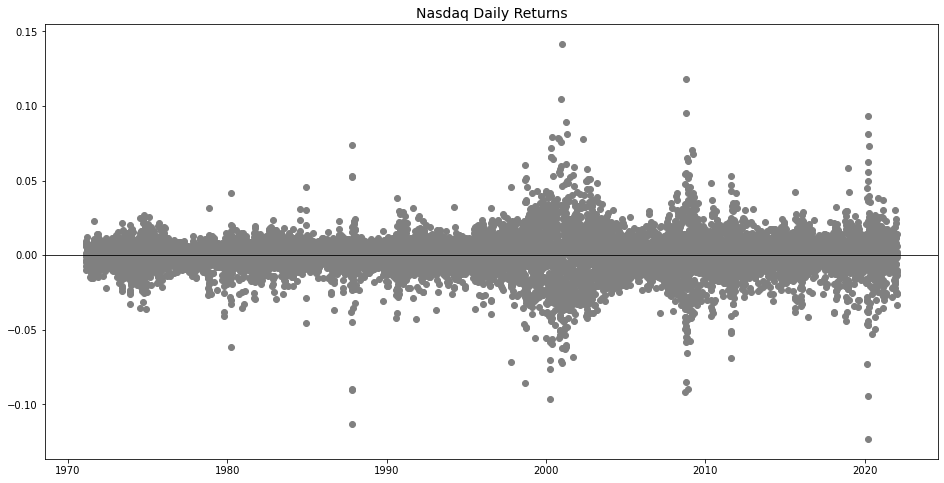

In [16]:
#data['Return'].plot()
plt.scatter(data.index, data['Return'], color = 'grey')
plt.title('Nasdaq Daily Returns (Scatter Plot)', fontsize = 14)
plt.axhline(0, color = 'black', linewidth = 0.8)

plt.show()

---

#### III) Analyzing Nasdaq's Return Distribution

The first step is to "normalize" the return series:

##### <center> ScaledRt = (Rt - μ)/σ

Where μ is the Mean and σ is the Standard Deviation, also known as "Volatility".

In [52]:
data['Scaled Returns'] = (data['Return'] - mean)/stdev
data['Scaled Returns'][0] = 0

data

,Open,High,Low,Close,Adj Close,Volume,Return,Scaled Returns
Date,,,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0,0.000000,0.000000
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0,0.008400,0.634812
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0,-0.000793,-0.100638
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0,-0.000695,-0.092753
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0,0.007548,0.566645


The Scaled Returns now have a Mean 0 and a Standard Deviation of 1. However, the distribution of this dataset cannot be considered Normal. Calculating the third and fourth moments (Skewness and Kurtosis, respectively) demonstrate that.

In [81]:
mean = data['Return'].mean()

stdev = np.sqrt(data['Return'].var())

skew = data['Scaled Returns'].skew()

kurtosis = data['Scaled Returns'].kurt()

max_scaled = data['Scaled Returns'].max()
min_scaled = data['Scaled Returns'].min()

print('Scaled Return:')
print('- Mean: {}'.format(round(mean * 100, 1)))
print('- Standard Deviation: {}'.format(round(stdev * 100, 1)))
print('- Maximum: {}'.format(round(max_scaled, 1)))
print('- Minimum: {}'.format(round(min_scaled, 1)))
print('- Skewness: {}'.format(round(skew, 1)))
print('- Kurtosis: {}'.format(round(kurtosis, 1)))

Scaled Return:
- Mean: 0.0
- Standard Deviation: 1.3
- Maximum: 11.3
- Minimum: -9.9
- Skewness: -0.2
- Kurtosis: 10.2


Another statistic worth noting is the Maximum/Minimum Scaled Returns, which confirms the existence of Fat-Tails.

In the words of a Sage Quant:
"*If it was really normally distributed, you would have to wait longer than the lifetime of the Universe before you get an 11 standard deviation move.*"

Although it happened in 20 years of data.

###### <center> Visualization: Nasdaq Scaled Daily Returns (histogram)

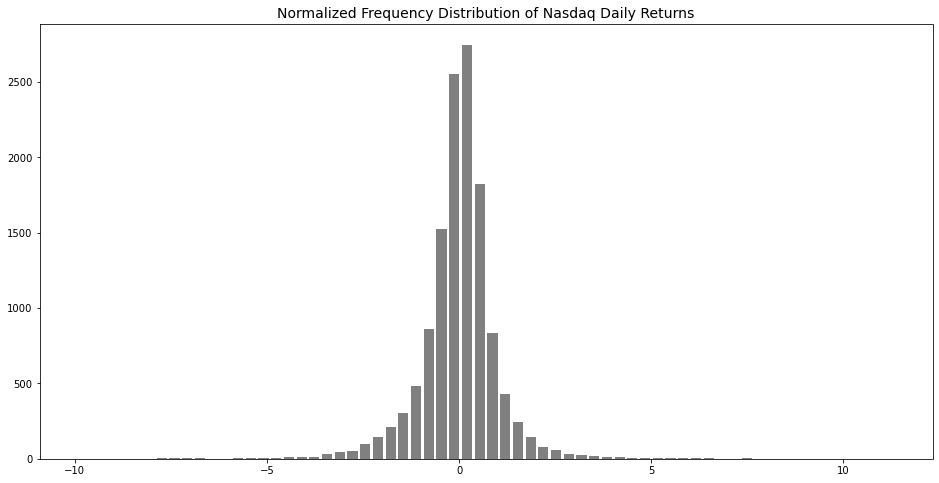

In [74]:
plt.hist(data['Scaled Returns'], bins = int(len(data)/200), color = 'grey', rwidth = 0.8)
plt.title('Normalized Frequency Distribution of Nasdaq Daily Returns', fontsize = 14)
plt.grid(False)

plt.show()

###### <center> Visualization: Nasdaq x Normal (pdf)

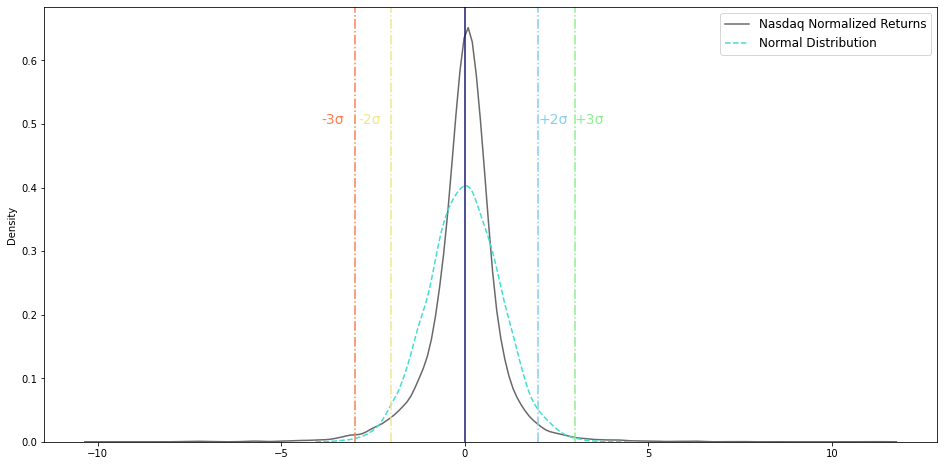

In [73]:
normal = np.random.normal(data['Scaled Returns'].mean(), data['Scaled Returns'].std(), len(data))

high1 = np.round(data['Scaled Returns'].mean() + 2*(data['Scaled Returns'].std()), 2) 
low1 = np.round(data['Scaled Returns'].mean() - 2*(data['Scaled Returns'].std()), 2) 
high2 = np.round(data['Scaled Returns'].mean() + 3*(data['Scaled Returns'].std()), 2) 
low2 = np.round(data['Scaled Returns'].mean() - 3*(data['Scaled Returns'].std()), 2)

sns.distplot(data['Scaled Returns'], hist = False, color = 'dimgray')
sns.distplot(normal, hist = False, color = 'turquoise', kde_kws = {'linestyle':'--'})
plt.axvline(data['Scaled Returns'].mean(), color = 'midnightblue')
plt.axvline(high1, color = 'skyblue', linestyle = '-.')
plt.text(high1, 0.5, '+2σ', color = 'skyblue', fontsize = 14)
plt.axvline(high2, color = 'lightgreen', linestyle = '-.')
plt.text(high2, 0.5, '+3σ', color = 'lightgreen', fontsize = 14)
plt.axvline(low1, color = 'khaki', linestyle = '-.')
plt.text(low1 - 0.9, 0.5, '-2σ', color = 'khaki', fontsize = 14)
plt.axvline(low2, color = 'coral', linestyle = '-.')
plt.text(low2 - 0.9, 0.5, '-3σ', color = 'coral', fontsize = 14)
plt.xlabel('')
plt.grid(False)
plt.legend({'Nasdaq Normalized Returns': data['Scaled Returns'], 'Normal Distribution': normal}, fontsize = 12)

plt.show()

---

##### IV) Concluding Remarks

Even though the distribution analyzed is far from Normal, the assumption is that the empirical returns can be modelled by a Normal Distribution (pragmatical approach), which makes it possible to derive a model aimed at forecasting the asset's future price path. 

This framework will lead to the Wiener Process and the Geometric Brownian Motion further ahead.

---

Author: [Renan Pereira Bento](https://www.linkedin.com/in/renan-bento/)